# Convolutional neural network model notebook

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import keras

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

module_path = os.path.abspath(r"E:\Nikita\Kaggle\Kaggle-NMA-Competition")
if module_path not in sys.path:
    sys.path.append(module_path)
from src import data_prepare
from src import feature_extraction

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Load and clean data

In [2]:
post, thread=data_prepare.load_train_data()
post_test, thread_test=data_prepare.load_test_data()
label_map=data_prepare.load_label_map()

In [3]:
train_data_to_clean=data_prepare.get_all_text_data_from_posts(post, thread)
test_data_to_clean=data_prepare.get_all_text_data_from_posts(post_test, thread_test)

clean_train_data = [data_prepare.clean(s) for s in thread["thread_name"]]
clean_test_data = [data_prepare.clean(s) for s in thread_test["thread_name"]]

## Vectorize text data and get additional features

In [4]:
vectorizer = TfidfVectorizer(min_df=3,sublinear_tf=True, norm='l2', encoding='latin-1', ngram_range=(1, 1))

train_data_features = vectorizer.fit_transform(clean_train_data).toarray()

test_data_features = vectorizer.transform(clean_test_data).toarray()

In [5]:
train_data_features=feature_extraction.get_features(post, thread, train_data_features)
test_data_features=feature_extraction.get_features(post_test, thread_test, test_data_features)

## Reshape and split data  

In [6]:
X_test=test_data_features
X_train=train_data_features
y_train=thread["thread_label_id"]

In [7]:
X_train=X_train.reshape(len(thread),115,1)
X_test=X_test.reshape(len(thread_test),115,1)

print(X_train.shape,X_test.shape)

(358, 115, 1) (236, 115, 1)


In [8]:
classes=np.unique(y_train)
classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [9]:
from keras.utils import to_categorical
train_Y_one_hot = to_categorical(y_train)

In [10]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(X_train, train_Y_one_hot, test_size=0.1, random_state=24)

## Build the network

In [11]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D,GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [12]:
batch_size = 10
epochs = 40
num_classes = len(classes)

In [13]:
model = Sequential()
model.add(Conv1D(10, 5, activation='relu',input_shape=(115,1)))
model.add(MaxPooling1D(5))
model.add(Conv1D(115, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(115, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))

In [14]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 111, 10)           60        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 22, 10)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18, 115)           5865      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 115)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 115)               13340     
_________________________________________________________________
dense_2 (Dense)              (None, 13)                1508      
Total params: 20,773
Trainable params: 20,773
Non-trainable params: 0
_________________________________________________________________


## Train and plot accuracy and loss functions

In [16]:
history = model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Train on 322 samples, validate on 36 samples
Epoch 1/40
322/322 [==============================] - 1s 2ms/step - loss: 2.1233 - acc: 0.4130 - val_loss: 1.6225 - val_acc: 0.5278
Epoch 2/40
322/322 [==============================] - 0s 420us/step - loss: 1.4187 - acc: 0.5807 - val_loss: 1.3837 - val_acc: 0.5000
Epoch 3/40
322/322 [==============================] - 0s 426us/step - loss: 1.2881 - acc: 0.5994 - val_loss: 1.4038 - val_acc: 0.5278
Epoch 4/40
322/322 [==============================] - 0s 444us/step - loss: 1.2796 - acc: 0.5932 - val_loss: 1.3420 - val_acc: 0.5000
Epoch 5/40
322/322 [==============================] - 0s 431us/step - loss: 1.2597 - acc: 0.5963 - val_loss: 1.3199 - val_acc: 0.5278
Epoch 6/40
322/322 [==============================] - 0s 409us/step - loss: 1.2459 - acc: 0.5901 - val_loss: 1.3250 - val_acc: 0.5000
Epoch 7/40
322/322 [==============================] - 0s 416us/step - loss: 1.2395 - acc: 0.5932 - val_loss: 1.3173 - val_acc: 0.5278
Epoch 8/40
322/322 

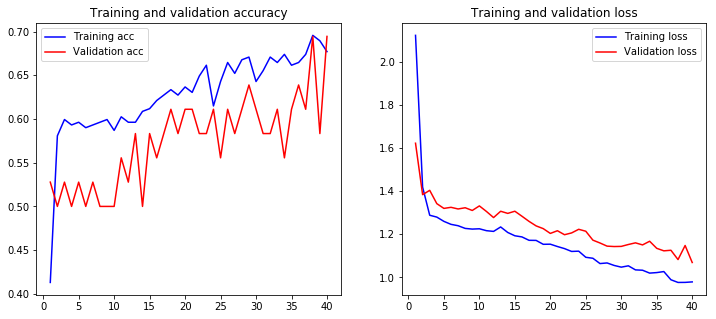

In [17]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

## Predict and save

In [18]:
predicted_classes = model.predict(X_test)

In [19]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [20]:
total=pd.Series(predicted_classes)
ans = pd.concat([thread_test["thread_num"],total], axis=1, keys=['thread_num', 'thread_label_id'])
ans=ans.set_index("thread_num")
ans.head()

,thread_label_id
thread_num,
126856,8
132415,8
134482,0
133728,1
134270,8


In [23]:
path=os.path.join(module_path,"submissions")
ans.to_csv(os.path.join(path,"sol29.csv"))